In [1]:
# Cell 1: Imports
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import time
from tqdm.auto import tqdm # Thanh tiến trình
import numpy as np

# Import các file của bạn
from rtfm_model import RTFM_TFM
from rtfm_loss import rtfm_loss_fn
from rtfm_dataset import RTFMDataset, BalancedSampler

print("Import hoàn tất.")

Import hoàn tất.


c:\Users\LHD\Desktop\PBL6\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cell 2: Cấu hình (Có thêm Validation)
# --- Cấu hình ---
device = "cuda" if torch.cuda.is_available() else "cpu"

# Đường dẫn file list mới tạo
TRAIN_LIST = Path("feature_lists/rtfm_train.list")
VAL_LIST = Path("feature_lists/rtfm_val.list") # File validation

BATCH_SIZE = 60 # 30 normal, 30 abnormal
LEARNING_RATE = 0.001
EPOCHS = 50

CHECKPOINT_PATH = Path("rtfm_checkpoint_stage1.pth")
FINAL_MODEL_PATH = Path("rtfm_tfm_model.pth")

print(f"Thiết bị: {device}")
print(f"Train list: {TRAIN_LIST}")
print(f"Val list:   {VAL_LIST}")

Thiết bị: cpu
Train list: feature_lists\rtfm_train.list
Val list:   feature_lists\rtfm_val.list


In [3]:
# Cell 3: Tải Model & Data (Train + Val)

# 1. Model
model = RTFM_TFM(input_dim=2048, num_layers=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 2. Train Dataset & Sampler
train_dataset = RTFMDataset(str(TRAIN_LIST))
# Train bắt buộc dùng BalancedSampler để tính Ranking Loss
train_sampler = BalancedSampler(train_dataset, BATCH_SIZE)
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler)

# 3. Validation Dataset & Sampler
# Lưu ý: Để tính Ranking Loss chuẩn trên tập Val, ta cũng nên dùng BalancedSampler
# để đảm bảo mỗi batch Val đều có cả Normal và Abnormal để so sánh.
val_dataset = RTFMDataset(str(VAL_LIST))
val_sampler = BalancedSampler(val_dataset, BATCH_SIZE) 
val_loader = DataLoader(val_dataset, batch_sampler=val_sampler)

print(f"Data Train: {len(train_dataset)} video")
print(f"Data Val:   {len(val_dataset)} video")

Data Train: 1292 video
Data Val:   318 video


In [4]:
# Cell 4: Vòng lặp Huấn luyện & Validation

# Lịch sử để vẽ biểu đồ
history = {
    "train_loss": [],
    "val_loss": []
}

start_epoch = 0

# Resume nếu có checkpoint
if CHECKPOINT_PATH.exists():
    print(f"Tìm thấy checkpoint: {CHECKPOINT_PATH}. Đang tải...")
    ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    start_epoch = ckpt['epoch'] + 1
    history = ckpt.get('history', history)
    print(f"Tiếp tục từ Epoch {start_epoch + 1}")

print("--- BẮT ĐẦU TRAINING ---")

for epoch in range(start_epoch, EPOCHS):
    # --- TRAIN ---
    model.train()
    train_loss_accum = 0.0
    
    # Progress bar cho Train
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
    
    for features, labels in pbar:
        features = features.to(device)
        
        # Fix shape 10-crop [B, T, 10, C] -> [B, T, C]
        if features.dim() == 4:
            features = torch.mean(features, dim=2)
            
        # Tách normal/abnormal
        normal_features = features[labels == 0]
        abnormal_features = features[labels == 1]
        
        if len(normal_features) == 0 or len(abnormal_features) == 0:
            continue # Bỏ qua batch lỗi
            
        optimizer.zero_grad()
        
        out_normal = model(normal_features)
        out_abnormal = model(abnormal_features)
        
        loss = rtfm_loss_fn(out_normal, out_abnormal)
        
        loss.backward()
        optimizer.step()
        
        train_loss_accum += loss.item()
        pbar.set_postfix(loss=loss.item())
    
    avg_train_loss = train_loss_accum / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    
    # --- VALIDATION ---
    model.eval()
    val_loss_accum = 0.0
    
    with torch.no_grad():
        # Không cần tqdm cho Val để đỡ rối log
        for features, labels in val_loader:
            features = features.to(device)
            if features.dim() == 4:
                features = torch.mean(features, dim=2)
                
            normal_features = features[labels == 0]
            abnormal_features = features[labels == 1]
            
            if len(normal_features) == 0 or len(abnormal_features) == 0:
                continue
            
            out_normal = model(normal_features)
            out_abnormal = model(abnormal_features)
            
            loss = rtfm_loss_fn(out_normal, out_abnormal)
            val_loss_accum += loss.item()
            
    avg_val_loss = val_loss_accum / len(val_loader) if len(val_loader) > 0 else 0.0
    history["val_loss"].append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    
    
    # Lưu checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
    }, CHECKPOINT_PATH)

# Lưu model cuối
torch.save(model.state_dict(), FINAL_MODEL_PATH)
print("Đã lưu model cuối cùng.")

--- BẮT ĐẦU TRAINING ---


Epoch 1/50 | Train Loss: 0.1756 | Val Loss: 1.0956


Epoch 2/50 | Train Loss: 0.0135 | Val Loss: 1.5169


Epoch 3/50 | Train Loss: 0.0051 | Val Loss: 3.9602


Epoch 4/50 | Train Loss: 0.0324 | Val Loss: 10.7848


Epoch 5/50 | Train Loss: 0.0044 | Val Loss: 3.2463


Epoch 6/50 | Train Loss: 0.0168 | Val Loss: 11.1057


Epoch 7/50 | Train Loss: 0.0094 | Val Loss: 18.0636


Epoch 8/50 | Train Loss: 0.0039 | Val Loss: 13.0414


Epoch 9/50 | Train Loss: 0.0016 | Val Loss: 10.9407


Epoch 10/50 | Train Loss: 0.0092 | Val Loss: 14.0978


Epoch 11/50 | Train Loss: 0.0101 | Val Loss: 39.1310


Epoch 12/50 | Train Loss: 0.1580 | Val Loss: 15.7626


Epoch 13/50 | Train Loss: 0.0045 | Val Loss: 6.7516


Epoch 14/50 | Train Loss: 0.0064 | Val Loss: 3.2338


Epoch 15/50 | Train Loss: 0.0440 | Val Loss: 7.1544


Epoch 16/50 | Train Loss: 0.1242 | Val Loss: 6.8223


Epoch 17/50 | Train Loss: 0.0088 | Val Loss: 5.6343


Epoch 18/50 | Train Loss: 0.0099 | Val Loss: 7.2107


Epoch 19/50 | Train Loss: 0.0187 | Val Loss: 11.9044


Epoch 20/50 | Train Loss: 0.0032 | Val Loss: 7.6565


Epoch 21/50 | Train Loss: 0.0046 | Val Loss: 7.2908


Epoch 22/50 | Train Loss: 0.0012 | Val Loss: 5.8162


Epoch 23/50 | Train Loss: 0.0000 | Val Loss: 3.6904


Epoch 24/50 | Train Loss: 0.0048 | Val Loss: 4.4056


Epoch 25/50 | Train Loss: 0.0175 | Val Loss: 2.9832


Epoch 26/50 | Train Loss: 0.0095 | Val Loss: 3.9478


Epoch 27/50 | Train Loss: 0.0076 | Val Loss: 12.7569


Epoch 28/50 | Train Loss: 0.1707 | Val Loss: 37.6411


Epoch 29/50 | Train Loss: 0.0443 | Val Loss: 16.3742


Epoch 30/50 | Train Loss: 0.0065 | Val Loss: 9.8659


Epoch 31/50 | Train Loss: 0.0048 | Val Loss: 9.5932


Epoch 32/50 | Train Loss: 0.0024 | Val Loss: 9.1756


Epoch 33/50 | Train Loss: 0.0065 | Val Loss: 6.6585


Epoch 34/50 | Train Loss: 0.0077 | Val Loss: 10.3410


Epoch 35/50 | Train Loss: 0.0038 | Val Loss: 8.3626


Epoch 36/50 | Train Loss: 0.0023 | Val Loss: 9.4809


Epoch 37/50 | Train Loss: 0.0193 | Val Loss: 21.2572


Epoch 38/50 | Train Loss: 0.0059 | Val Loss: 11.0079


Epoch 39/50 | Train Loss: 0.0016 | Val Loss: 18.4452


Epoch 40/50 | Train Loss: 0.0000 | Val Loss: 9.5690


Epoch 41/50 | Train Loss: 0.0000 | Val Loss: 15.4094


Epoch 42/50 | Train Loss: 0.0000 | Val Loss: 9.4121


Epoch 43/50 | Train Loss: 0.0000 | Val Loss: 19.2980


Epoch 44/50 | Train Loss: 0.0000 | Val Loss: 16.0591


Epoch 45/50 | Train Loss: 0.0000 | Val Loss: 15.8976


Epoch 46/50 | Train Loss: 0.0000 | Val Loss: 14.9917


Epoch 47/50 | Train Loss: 0.0000 | Val Loss: 13.1829


Epoch 48/50 | Train Loss: 0.0000 | Val Loss: 14.4213


Epoch 49/50 | Train Loss: 0.0000 | Val Loss: 18.1413


Epoch 50/50 | Train Loss: 0.0000 | Val Loss: 13.1967
Đã lưu model cuối cùng.


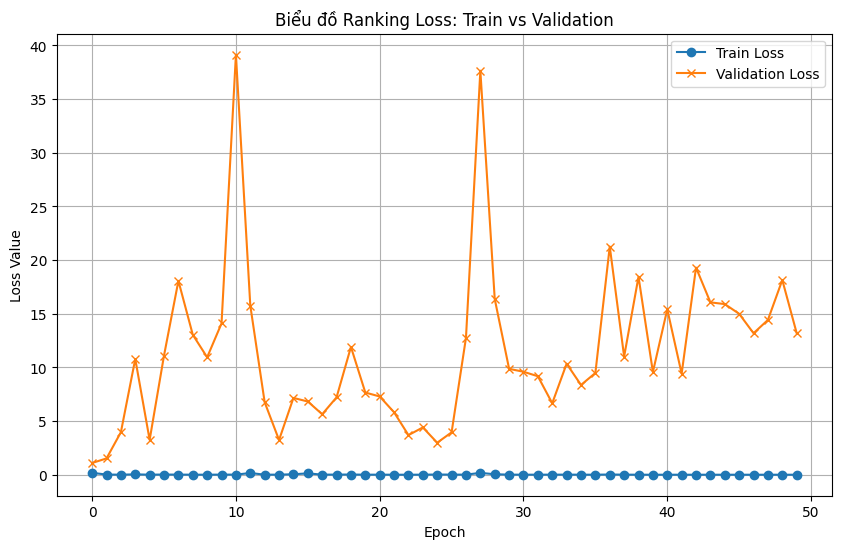

In [5]:
# Cell 5: Vẽ biểu đồ Loss (So sánh Train vs Val)

plt.figure(figsize=(10, 6))
plt.plot(history["train_loss"], label="Train Loss", marker='o')
plt.plot(history["val_loss"], label="Validation Loss", marker='x')
plt.title("Biểu đồ Ranking Loss: Train vs Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.grid(True)
plt.show()